# 固收小组作业

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os

In [2]:
## 定义参数类
#-- define a class including all parameters
class Para():
    path_data = './data/data.xlsx'
    path_results = './results/'
    
    propotion_in_sample = 0.6 # propotion of in-sample-data
    
    seed = 0 #-- random seed
    percent_cv = 0.2 #-- percentage of cross validation samples （交叉验证样本的百分比）
    n_splits = 3
    xgbc_n_estimators = 200 #-- xgboost classifier parameter
    xgbc_learning_rate = 0.1 #-- xgboost classifier parameter
    xgbc_subsample_C = 0.95 #-- xgboost classifier parameter
    xgbc_max_depth = 1 #-- xgboost classifier parameter

In [3]:
para = Para()
df = pd.read_excel(para.path_data)

In [4]:
## 划分样本内和样本外数据
total_data_number = df.shape[0]
in_sample_data_number = int(para.propotion_in_sample*total_data_number)
out_sample_data_number = total_data_number - in_sample_data_number

#-- 提取出第0-in_sample_data_number-1行的数据 为样本内的数据
X_in_sample = df.iloc[:in_sample_data_number,4:-5]  
y_in_sample = df.iloc[:in_sample_data_number,-5:-1]
y_in_sample_true = df.iloc[:in_sample_data_number,0:4]

#-- 提取出第in_sample_data_number及之后的数据 为样本外的数据
X_out_sample = df.iloc[in_sample_data_number:,4:-5]
y_true_test_total = df.iloc[in_sample_data_number:,-5:-1]
y_true_return = df.iloc[in_sample_data_number:,0:4]
#print(X_in_sample)
#print(y_in_sample)
#print(X_out_sample)
#print(y_true_test_total)
#print(y_true_return)

In [5]:
## 输出基本信息
#-- 数据信息
print("## Basic Information of Data")
print("#-- Total sample size = ", total_data_number)
print("#-- In-sample size = ", in_sample_data_number, "  //from 0 to %d"%(in_sample_data_number-1))
print("#-- Out-sample size = ", out_sample_data_number, " //form ", in_sample_data_number, " to %d"%(total_data_number-1))

print("\n#-- Summary Statistics：")
print(df.describe().round(2))


## Basic Information of Data
#-- Total sample size =  461
#-- In-sample size =  276   //from 0 to 275
#-- Out-sample size =  185  //form  276  to 460

#-- Summary Statistics：
          yr2     yr3     yr4     yr5        PI     Cps      Hw      Emp  \
count  461.00  461.00  461.00  461.00    461.00  461.00  461.00   461.00   
mean     0.51    0.84    1.04    1.01   5937.17   80.77   79.16   686.44   
std      1.94    3.56    4.93    6.05   2052.69    4.74   16.52   160.20   
min     -5.59  -10.43  -13.54  -17.55   2806.10   68.52   49.00   498.00   
25%     -0.91   -1.62   -2.34   -3.28   4156.40   77.94   65.63   575.30   
50%      0.48    0.60    0.66    0.55   5723.40   80.79   79.00   613.90   
75%      1.88    3.22    4.31    5.01   7322.10   83.67   92.08   747.20   
max      5.97   10.26   14.38   16.89  10077.00   91.64  115.13  1177.40   

       Avghrs   Starts  ...  Exrate     CPI    Sent     Mwd      CP  yr2_bin  \
count  461.00   461.00  ...  461.00  461.00  461.00  461.00 

## 回归模块


In [6]:
## 输出回归的基本信息
## 那in-sample作为训练样本，把out-sample作为测试样本
ols_train_sample = df.iloc[:in_sample_data_number,:]
ols_test_sample = df.iloc[in_sample_data_number:,]
ols_train_sample = pd.DataFrame(ols_train_sample)
ols_test_sample = pd.DataFrame(ols_test_sample)
print(ols_test_sample.head())
print(ols_train_sample.head())

          yr2       yr3       yr4       yr5      PI      Cps     Hw    Emp  \
276  0.191829  0.171111  0.096393 -0.084386  6414.1  84.0137  104.0  680.8   
277  1.024650  1.880360  3.066630  3.965420  6422.1  84.1942  100.0  675.0   
278  0.650481  1.211440  2.278430  2.414670  6455.5  84.6031  104.0  671.9   
279 -0.235051 -0.267730  0.267099  0.487193  6460.7  84.7428  102.0  665.7   
280 -0.856257 -1.454250 -1.739130 -1.692160  6503.2  85.0001  104.0  663.3   

     Avghrs  Starts  ...  Exrate   CPI      Sent    Mwd       CP  yr2_bin  \
276    40.3    1493  ...   89.11  78.2 -0.212660  3.588  1.30560        1   
277    40.3    1492  ...   89.18  72.8 -0.159926  3.574  1.03860        1   
278    40.5    1522  ...   87.04  71.5  0.011812  3.481  0.43864        1   
279    40.5    1569  ...   84.72  70.9 -0.294311  3.605  0.83175        0   
280    40.3    1563  ...   84.33  69.8 -0.383453  3.578  0.84603        0   

     yr3_bin  yr4_bin  yr5_bin  pread  
276        1        1       

In [7]:
def draw_OLS(results, yTest, yFit, x1, y_maturity):
    prstd, ivLow, ivUp = wls_prediction_std(results) # 返回标准偏差和置信区间
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(x1, yTest, 'o', label="data")  # 实验数据（原始数据+误差）
    ax.plot(x1, yFit, 'r-', label="OLS")  # 拟合数据
    ax.plot(x1, ivUp, '--',color='orange', label="ConfInt")  # 置信区间 上届
    ax.plot(x1, ivLow, '--',color='orange')  # 置信区间 下届
    ax.legend(loc='best')  # 显示图例
    plt.xlabel('months')
    plt.ylabel('yr'+str(y_maturity))
    plt.title("In-sample: "+str(y_maturity)+"-year maturity bonds")
    plt.show()
    return

## yr2 OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    yr2   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     64.25
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           5.61e-71
Time:                        11:31:38   Log-Likelihood:                -415.19
No. Observations:                 276   AIC:                             856.4
Df Residuals:                     263   BIC:                             903.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7800

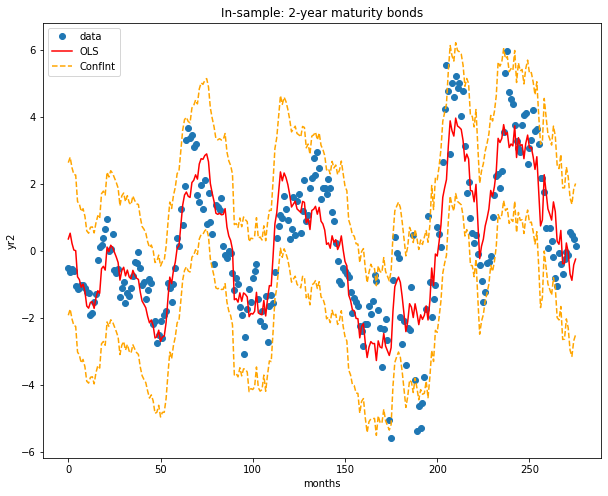


## yr3 OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    yr2   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     64.25
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           5.61e-71
Time:                        11:31:38   Log-Likelihood:                -415.19
No. Observations:                 276   AIC:                             856.4
Df Residuals:                     263   BIC:                             903.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.780

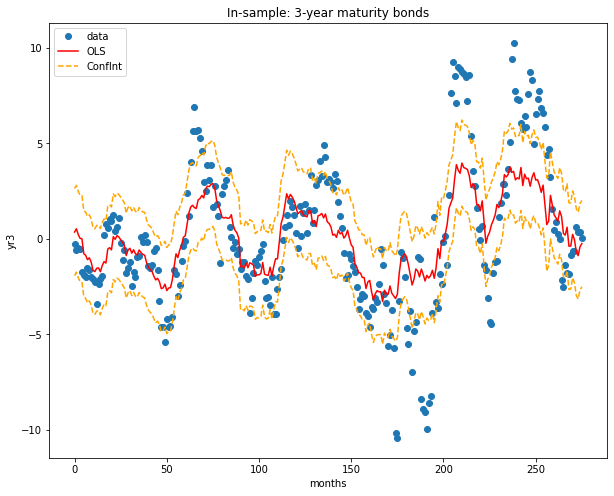


## yr4 OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    yr2   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     64.25
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           5.61e-71
Time:                        11:31:39   Log-Likelihood:                -415.19
No. Observations:                 276   AIC:                             856.4
Df Residuals:                     263   BIC:                             903.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.780

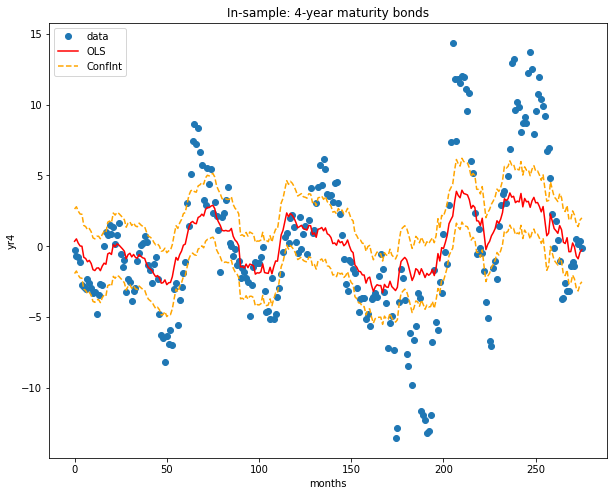


## yr5 OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                    yr2   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     64.25
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           5.61e-71
Time:                        11:31:39   Log-Likelihood:                -415.19
No. Observations:                 276   AIC:                             856.4
Df Residuals:                     263   BIC:                             903.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.780

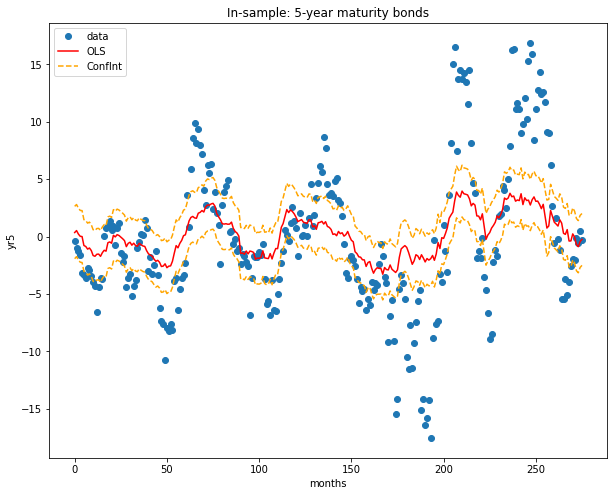

In [8]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
#-- 生成被解释变量
y2_ols_in_sample = y_in_sample_true.iloc[:,0]
y3_ols_in_sample = y_in_sample_true.iloc[:,1]
y4_ols_in_sample = y_in_sample_true.iloc[:,2]
y5_ols_in_sample = y_in_sample_true.iloc[:,3]

y2_ols_out_sample = y_true_return.iloc[:,0]
y3_ols_out_sample = y_true_return.iloc[:,1]
y4_ols_out_sample = y_true_return.iloc[:,2]
y5_ols_out_sample = y_true_return.iloc[:,3]

#-- 解释变量中加入常数项
X_in_sample_constant = sm.add_constant(X_in_sample)
X_out_sample_constant = sm.add_constant(X_out_sample)
#print(X_in_sample_constant)

#-- 模型建立
model2 = sm.OLS(y2_ols_in_sample,X_in_sample_constant)
model3 = sm.OLS(y3_ols_in_sample,X_in_sample_constant)
model4 = sm.OLS(y4_ols_in_sample,X_in_sample_constant)
model5 = sm.OLS(y5_ols_in_sample,X_in_sample_constant)

#-- 训练模型
result2 = model2.fit()
result3 = model2.fit()
result4 = model2.fit()
result5 = model2.fit()

#-- 模型拟合的y值
y2_fit = result2.fittedvalues
y3_fit = result3.fittedvalues
y4_fit = result4.fittedvalues
y5_fit = result5.fittedvalues

#-- 获得回归参数
para2 = result2.params
para3 = result3.params
para4 = result4.params
para5 = result5.params


#-- 输出结果
print("## yr2 OLS Regression Results:")
print(result2.summary())
draw_OLS(result2, y2_ols_in_sample, y2_fit, X_in_sample.index, 2)

print("\n## yr3 OLS Regression Results:")
print(result3.summary())
draw_OLS(result3, y3_ols_in_sample, y3_fit, X_in_sample.index, 3)

print("\n## yr4 OLS Regression Results:")
print(result4.summary())
draw_OLS(result4, y4_ols_in_sample, y4_fit, X_in_sample.index, 4)

print("\n## yr5 OLS Regression Results:")
print(result5.summary())
draw_OLS(result5, y5_ols_in_sample, y5_fit, X_in_sample.index, 5)

In [9]:
def RobustnessTest(params, x_test, y_test, y_maturity):
    time_index = y_test.index
    params = params.values
    y_test = y_test.values
    y_mean = np.mean(y_test)
    x_test = x_test.values
    pred = np.dot(x_test, params)
    
    ## 计算R方
    #-- 计算残差平方和
    error2 = []
    for i in range(len(y_test)):
        error2.append((pred[i]-y_test[i])**2)
    e = sum(error2) 

    #-- 计算总离差平方和
    sst = []
    for i in range(len(y_test)):
        sst.append((y_test[i]-y_mean)**2)
    s = sum(sst)
    
    R2 = 1.0 - e/s
    print("Out-of-Sample R-squared:",R2)
    
    ## 预测图像
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(time_index, y_test, 'o', label="data")  # 测试数据
    ax.plot(time_index, pred, 'r-', label="OLS")  # 拟合数据
    ax.legend(loc='best')  # 显示图例
    plt.xlabel('months')
    plt.ylabel('yr'+str(y_maturity))
    plt.title("Out-sample: "+str(y_maturity)+"-year maturity bonds")
    plt.show()
    return


## yr2 OLS Out-sample Regression Results:
Out-of-Sample R-squared: -5.07001246600369


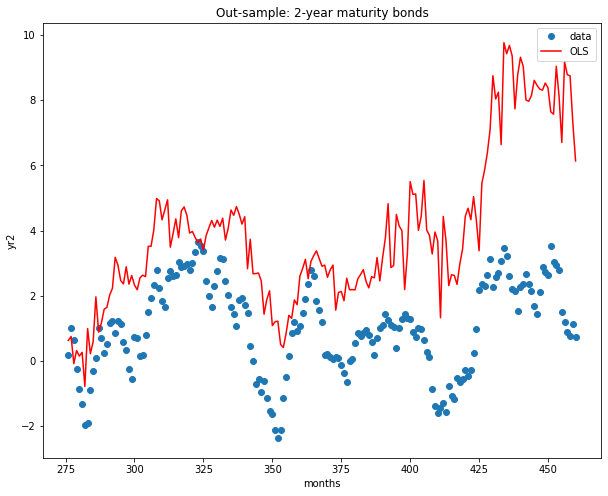

## yr3 OLS Out-sample Regression Results:
Out-of-Sample R-squared: -0.3281382860060127


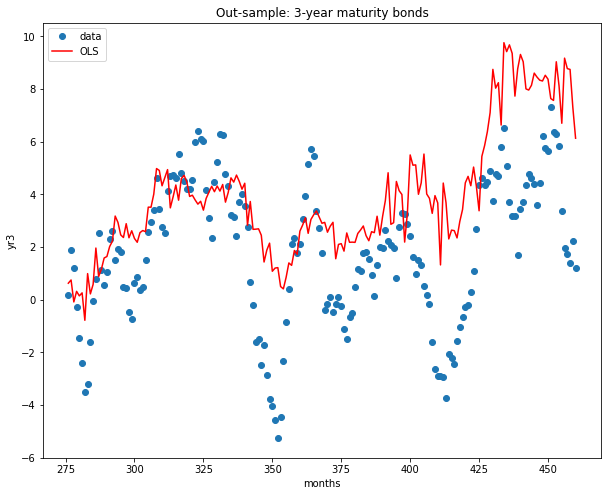

## yr4 OLS Out-sample Regression Results:
Out-of-Sample R-squared: 0.13464652583842363


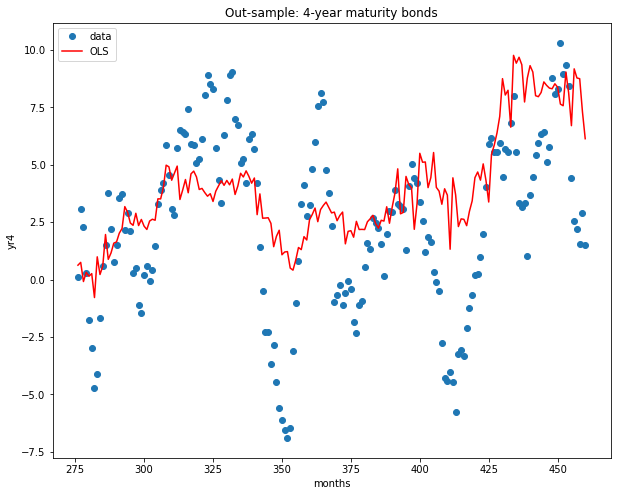

## yr5 OLS Out-sample Regression Results:
Out-of-Sample R-squared: 0.18029886284371066


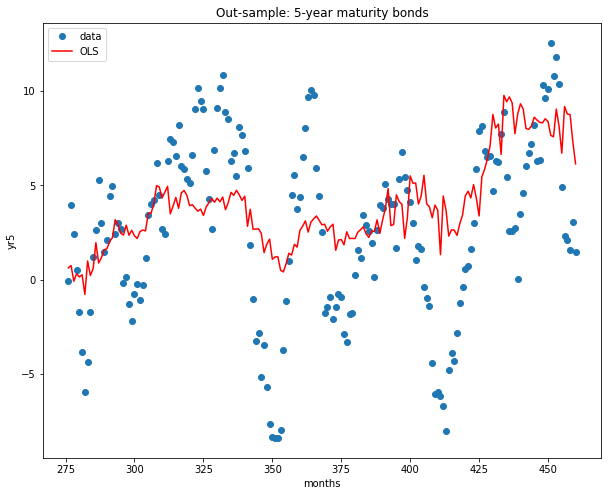

In [10]:
print("## yr2 OLS Out-sample Regression Results:")
RobustnessTest(para2, X_out_sample_constant, y2_ols_out_sample, 2)
print("## yr3 OLS Out-sample Regression Results:")
RobustnessTest(para3, X_out_sample_constant, y3_ols_out_sample, 3)
print("## yr4 OLS Out-sample Regression Results:")
RobustnessTest(para4, X_out_sample_constant, y4_ols_out_sample, 4)
print("## yr5 OLS Out-sample Regression Results:")
RobustnessTest(para5, X_out_sample_constant, y5_ols_out_sample, 5)

## 策略模块

In [11]:
## 输出基本信息
#-- 机器学习模型及参数
print("## Basic Information of Model:")
print("#-- method: XGboost")
print("#-- Hyperparameter:")
print("---- random_state = ", para.seed)
print("---- n_estimatiors = ", para.xgbc_n_estimators)
print("---- learning_rate = ", para.xgbc_learning_rate)
print("---- subsample = ", para.xgbc_subsample_C)
print("---- max_depth = ", para.xgbc_max_depth)
print("#-- cross validation method: TimeSeriesSplit")
print("---- n_splits = ", para.n_splits)
print("---- percentage of cross validation samples = ", para.percent_cv)

## Basic Information of Model:
#-- method: XGboost
#-- Hyperparameter:
---- random_state =  0
---- n_estimatiors =  200
---- learning_rate =  0.1
---- subsample =  0.95
---- max_depth =  1
#-- cross validation method: TimeSeriesSplit
---- n_splits =  3
---- percentage of cross validation samples =  0.2



### 第1次交叉验证：
TRAIN: 0 ~ 110 TEST: 111 ~ 165 

##--  expected returns on  2 -year bond
#---- 模型评价：
training set, accuracy = 0.99
training set, AUC = 1.00
cv set, accuracy = 0.67
cv set, AUC = 0.88
out_sample set, accuracy = 0.54
out_sample, AUC = 0.86

#---- 简单回测


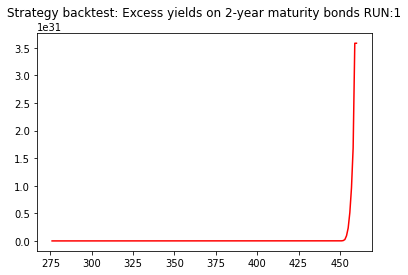

##--  expected returns on  3 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 1.00
cv set, accuracy = 0.60
cv set, AUC = 0.74
out_sample set, accuracy = 0.54
out_sample, AUC = 0.84

#---- 简单回测


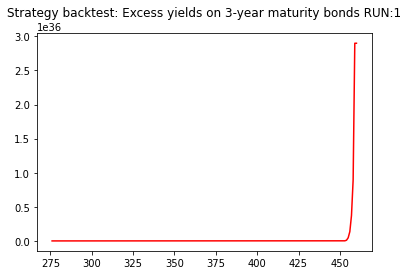

##--  expected returns on  4 -year bond
#---- 模型评价：
training set, accuracy = 0.98
training set, AUC = 1.00
cv set, accuracy = 0.56
cv set, AUC = 0.59
out_sample set, accuracy = 0.75
out_sample, AUC = 0.83

#---- 简单回测


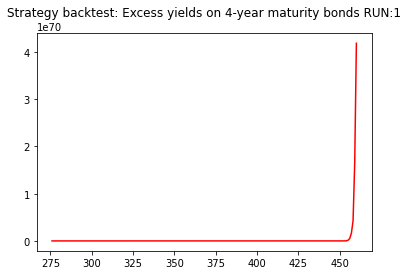

##--  expected returns on  5 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 1.00
cv set, accuracy = 0.62
cv set, AUC = 0.75
out_sample set, accuracy = 0.50
out_sample, AUC = 0.79

#---- 简单回测


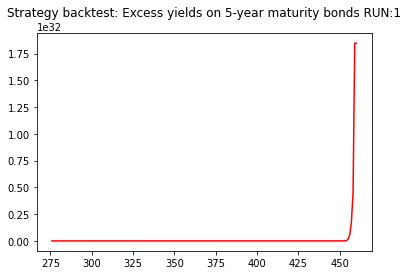


### 第2次交叉验证：
TRAIN: 0 ~ 165 TEST: 166 ~ 220 

##--  expected returns on  2 -year bond
#---- 模型评价：
training set, accuracy = 0.98
training set, AUC = 1.00
cv set, accuracy = 0.75
cv set, AUC = 0.86
out_sample set, accuracy = 0.51
out_sample, AUC = 0.88

#---- 简单回测


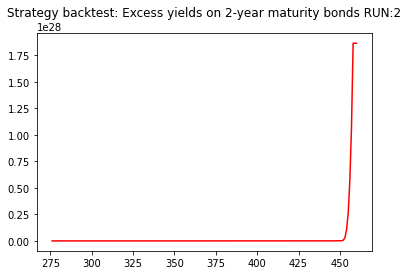

##--  expected returns on  3 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 1.00
cv set, accuracy = 0.78
cv set, AUC = 0.84
out_sample set, accuracy = 0.38
out_sample, AUC = 0.84

#---- 简单回测


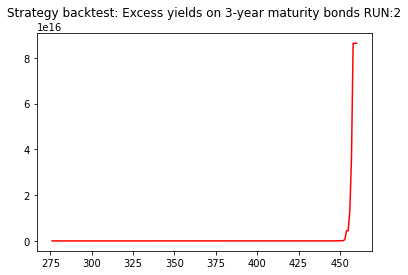

##--  expected returns on  4 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 1.00
cv set, accuracy = 0.75
cv set, AUC = 0.96
out_sample set, accuracy = 0.72
out_sample, AUC = 0.86

#---- 简单回测


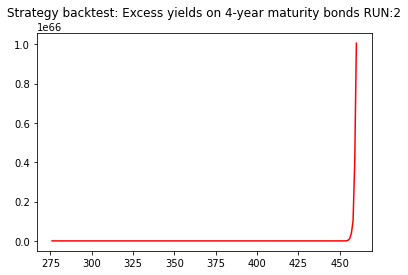

##--  expected returns on  5 -year bond
#---- 模型评价：
training set, accuracy = 0.98
training set, AUC = 1.00
cv set, accuracy = 0.82
cv set, AUC = 0.89
out_sample set, accuracy = 0.40
out_sample, AUC = 0.80

#---- 简单回测


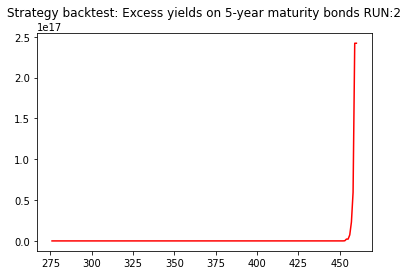


### 第3次交叉验证：
TRAIN: 0 ~ 220 TEST: 221 ~ 275 

##--  expected returns on  2 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 1.00
cv set, accuracy = 0.44
cv set, AUC = 0.74
out_sample set, accuracy = 0.58
out_sample, AUC = 0.85

#---- 简单回测


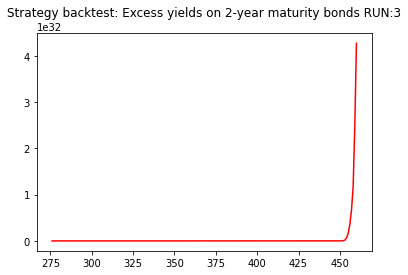

##--  expected returns on  3 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 1.00
cv set, accuracy = 0.36
cv set, AUC = 0.74
out_sample set, accuracy = 0.59
out_sample, AUC = 0.82

#---- 简单回测


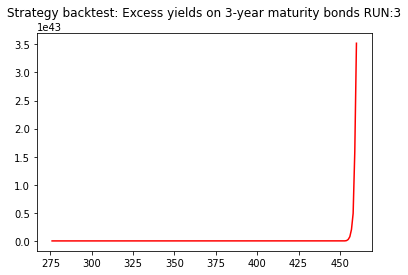

##--  expected returns on  4 -year bond
#---- 模型评价：
training set, accuracy = 0.96
training set, AUC = 0.99
cv set, accuracy = 0.36
cv set, AUC = 0.77
out_sample set, accuracy = 0.60
out_sample, AUC = 0.80

#---- 简单回测


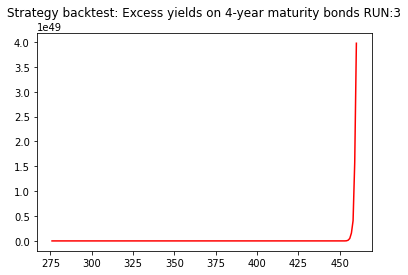

##--  expected returns on  5 -year bond
#---- 模型评价：
training set, accuracy = 0.97
training set, AUC = 0.99
cv set, accuracy = 0.40
cv set, AUC = 0.84
out_sample set, accuracy = 0.58
out_sample, AUC = 0.78

#---- 简单回测


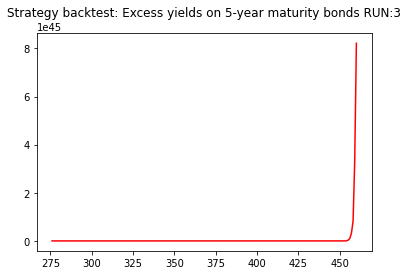

In [12]:
## 划分训练集和验证集
#-- generate train and cv data
from sklearn.model_selection import TimeSeriesSplit
test_size = int(in_sample_data_number*para.percent_cv)
time_series = TimeSeriesSplit(n_splits=para.n_splits, test_size=test_size)

## 模型设立
from xgboost import XGBClassifier
model = XGBClassifier(random_state=para.seed,
                      n_estimators=para.xgbc_n_estimators,
                      learning_rate=para.xgbc_learning_rate,
                      subsample=para.xgbc_subsample_C,
                      max_depth=para.xgbc_max_depth)

n = 1
for train_index, test_index in time_series.split(X_in_sample):
    print("\n### 第%d次交叉验证："%n)
    print("TRAIN:", train_index[0], "~", train_index[-1], "TEST:", test_index[0], "~", test_index[-1],'\n')
    X_train, X_test = X_in_sample.iloc[train_index,:], X_in_sample.iloc[test_index,:]
    y_train_total, y_test_total = y_in_sample.iloc[train_index,:], y_in_sample.iloc[test_index,:]
        
    ## 训练模型，交叉验证
    #-- train model, and perform cross validation
    #-- classification
    for i in range(4):
        print("##--  expected returns on ", i+2, "-year bond")
        y_train = y_train_total.iloc[:,i]
        y_test = y_test_total.iloc[:,i]
        y_test_true = y_true_return.iloc[:,i]
        #print(y_train)
        #print(y_test)
        #print(y_test_true)
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        model.fit(X_train,y_train)
        #-- y_pred: binary format; y_score: continious format
        y_pred_train = model.predict(X_train)
        #print(y_pred_train)
        y_score_train = model.predict_proba(X_train)[:,1]
        #print(y_score_train)
        y_pred_test = model.predict(X_test)
        #print(y_pred_test)
        y_score_test = model.predict_proba(X_test)[:,1]
        #print(y_score_test)

        ## 样本外预测
        y_pred_month = model.predict(X_out_sample)
        y_score_month = model.predict_proba(X_out_sample)[:,1]
        y_true_test = y_true_test_total.iloc[:,i]
        
        ## 模型评价       
        from sklearn import metrics
        print("#---- 模型评价：")
        print('training set, accuracy = %.2f'%metrics.accuracy_score(y_train, y_pred_train))
        print('training set, AUC = %.2f'%metrics.roc_auc_score(y_train, y_score_train))
        print('cv set, accuracy = %.2f'%metrics.accuracy_score(y_test, y_pred_test))
        print('cv set, AUC = %.2f'%metrics.roc_auc_score(y_test, y_score_test))
        print('out_sample set, accuracy = %.2f'%metrics.accuracy_score(y_true_test, y_pred_month))
        print('out_sample, AUC = %.2f'%metrics.roc_auc_score(y_true_test, y_score_month))
    
        ## 简易回测
        print('\n#---- 简单回测')
        start = in_sample_data_number
        end = total_data_number-1
        strategy = pd.DataFrame({'return':[0] * (end+1),'value':[1] * (end+1)})
        month_test = range(start, end+1)
        
        for i_month in month_test:
            strategy.iloc[i_month,0] = y_test_true.loc[i_month] * y_pred_month[i_month-start]
        
        strategy['value'] = (strategy['return'] + 1).cumprod()
        
        #-- plot the value
        import matplotlib.pyplot as plt
        plt.plot(month_test,strategy.loc[month_test,'value'],'r-')
        plt.title("Strategy backtest: Excess yields on "+str(i+2)+"-year maturity bonds RUN:"+str(n))
        result_path = para.path_results+"Strategy backtest_ExcessYields_"+str(i+2)+"-yearMaturityBonds_RUN"+str(n)+".png"
        plt.show()
        
    n = n+1
        